# Dimensionality reduction & analysis

Per Ensemble methods

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from collections import Counter
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier


import scikitplot as skplt
import seaborn as sns

In [52]:
# useful libraries
import math
import operator
import itertools
import statistics
import collections

from collections import OrderedDict
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions

from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split # Import train_test_split function


In [53]:
## Altri###

from sklearn.ensemble import *
from sklearn.tree import *


from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.naive_bayes import *
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.tree import *
from sklearn.metrics import *
import time
import warnings
warnings.filterwarnings("ignore")

In [54]:
from sklearn.feature_selection import VarianceThreshold

## Caricamento Dataset

In [55]:
train = pd.read_csv('../data/csv_files/train.csv')
X_train = train.drop(['subject', 'Activity','ActivityName'], axis=1)
y_train = train['Activity']


In [56]:
test = pd.read_csv('../data/csv_files/test.csv')
X_test = test.drop(['subject', 'Activity','ActivityName'], axis=1)
y_test = test['Activity']

## Caricamento funzioni DT e KNN

In [7]:
n_iter = 10
scoring = 'f1_weighted'
random_state = 42

# test_n_splits = 9
test_n_splits = 3

# Parametri globali DT
DT = DecisionTreeClassifier(random_state=42)
model_name = "DecisionTreeClassifier"

v_or_t_flag = "TST"
cmap = plt.cm.Blues
color = "blue"

# Parametri globali KNN
KNN = KNeighborsClassifier()

scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)


    # parametri dal report
DT_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1,2,4,6,8,9,10], #+ list(np.arange(1, len(X_train.columns) + 1, 100)),
    'min_samples_leaf': [2, 5, 10], 
    'min_samples_split': [2, 5, 10], 
    #'max_features': ['auto']

    #'class_weight': ['balanced', None, {0: 0.1, 1: 0.3, 2: 0.6}]
}

sqrt_records = round(math.sqrt(X_train.shape[1]))
k_range = list(range(2, sqrt_records+1, 2))
KNN_params = {
    'n_neighbors': k_range,
    'weights': ['uniform', 'distance']
}

def draw_roc_curve_mutliclass(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    lb.classes_.tolist()

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    by_test = lb.transform(y_test)
    by_pred = lb.transform(y_pred)
    for i in range(6):
        fpr[i], tpr[i], _ = roc_curve(by_test[:, i], by_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    roc_auc = roc_auc_score(by_test, by_pred, average=None)
    plt.figure(figsize=(8, 5))
    
    for i in range(6):
        plt.plot(fpr[i], tpr[i], 
                 label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20) 
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.show()
    
def plot_learning_curve(pipeline, X, y, scorer='accuracy', cv=5, train_sizes=np.linspace(.1, 1.0, 5), 
                        shuffle=False, random_state=None):

    train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, train_sizes=train_sizes, cv=cv,
                                                            scoring=scorer, n_jobs=-1, shuffle=shuffle,
                                                            random_state=random_state)

    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    plt.title('learning curve')
    plt.xlabel('training set size')
    plt.ylabel('score')

    plt.plot(train_sizes, mean_train_score, label='train score', color='navy', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_train_score + std_train_score,
                     mean_train_score - std_train_score, color='navy', alpha=0.2)
    plt.plot(train_sizes, mean_test_score, label='cross-validation score', color='darkorange', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_test_score + std_test_score,
                     mean_test_score - std_test_score, color='darkorange', alpha=0.2)

    plt.legend(loc='lower right').get_frame().set_facecolor('white')
    
def get_tuned_model(X_tr, y_tr, params):
    
    model_params = list(model_grid(X_tr).keys())
    # retrieve best hyperameters
    tmp_model_hyperparameters = dict((k, params[k]) for k in model_params if k in params)
    model_hyperparameters = {}
    for key, value in tmp_model_hyperparameters.items():
        key = key.split('model__')[1].replace("'", "")
        model_hyperparameters[key] = value
        
    tuned_model =  model.set_params(**model_hyperparameters)
    tuned_model.fit(X_tr, y_tr.values.ravel())
    return tuned_model

def plot_confusion_matrix(cm, classes, normalize):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s\'s %s classification report" % (model_name.capitalize(), v_or_t_flag.upper()))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s\'s %s confusion matrix" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_decision_boundary(X_tr, y_tr, model):
    pca = PCA(n_components=2)
    best_visualisation_scaler = StandardScaler()
    scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
    X = pca.fit_transform(scaled_X_tr)
    # X = pca.fit_transform(X_tr)
    y = y_tr.values.ravel()

    model.fit(X, y)
    plt.figure(figsize=(8, 5))
    fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
    plt.legend(loc='best')
    plt.grid(False)
    plt.show()




def tune_model(model, params, X_train, y_train, X_test,y_test):
    k_fold = StratifiedKFold(n_splits=3) 
    grid_search = GridSearchCV(model, params, n_jobs = -1, verbose =3, cv = k_fold, refit = 'f1_weighted')
    grid_search.fit(X_train, y_train.values.ravel())

    print()
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    print()

    best_params = grid_search.best_params_
    clf = grid_search.best_estimator_

    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)
    #tuned_model = get_tuned_model(X_train, y_train, best_params)

    # Prima visualizzazione
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
    print('Precision:', metrics.precision_score(y_test, y_pred, average='weighted'))
    print('Recall:', metrics.recall_score(y_test, y_pred, average='weighted'))

    print(classification_report(y_test, y_pred))

    # Seconda visualizzazione
    print("\n=== CROSS VALIDATION SCORES ===")
    scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10)
    print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))
    scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10, scoring='f1_macro')
    print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))


    #print("\n=== CONFUSION MATRIX ===")
    #cm = confusion_matrix(y_test, y_pred, labels=clf.classes_) # cmap=cmap
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)

    #disp.plot()                      
    #metrics.plot_confusion_matrix(clf, X_test, y_test)
    #plt.show()


    #print("\n=== Altre grafiche per visualizzazione===")
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, clf.classes_, True)
    plot_classification_report(y_test, y_pred)

    #plot_decision_boundary(X_train, y_train, tuned_model)  # passing random scaler

    #draw_roc_curve_mutliclass(y_test, y_pred)

    #print("\n=== CURVES===")
    #skplt.metrics.plot_roc(y_test, y_score)

    #plot_precision_recall(y_test, y_score)
    plt.show()


# Variance Threshold

#### Test different threshold

In [14]:
def retrieve_features_from_get_support(X_tr, mask):
    new_features = []
    for bool, feature in zip(mask, X_tr.columns):
        if bool:
            new_features.append(feature)
    return new_features

def variance_threshold_selection(X_tr, threshold, info_flag):
    variance_threshold_features = []
    selector = VarianceThreshold(threshold)
    selector.fit(X_tr)
    print("Threshold", threshold)
    if info_flag:
        print('Number of features used... ', Counter(selector.get_support())[True])
        print('Number of features ignored... ', Counter(selector.get_support())[False])
    else:
        mask = selector.get_support()
        variance_threshold_features = retrieve_features_from_get_support(X_tr, mask)
        print('Features used...\n', '\n'.join(variance_threshold_features))
    print()
    return selector, variance_threshold_features

In [15]:
thresholds = list(np.linspace(0, 0.2, 21))
Acc_list = []


for t in thresholds:
    selector, _ = variance_threshold_selection(X_train, t, True)
    sel = VarianceThreshold(threshold=t) #(.9 * (1 - .9))
    X_train_sel = sel.fit_transform(X_train)
    X_train_sel.shape 

    X_test_sel = sel.transform(X_test)
    clf = DecisionTreeClassifier( random_state=42)
    clf.fit(X_train_sel, y_train)

    y_pred = clf.predict(X_test_sel)

    print('---Accuracy %s' % accuracy_score(y_test, y_pred))
    Acc_list.append(accuracy_score(y_test, y_pred))
    print('---F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
    print('-------------------------')
    #print(classification_report(y_test, y_pred))

Threshold 0.0
Number of features used...  561
Number of features ignored...  0

---Accuracy 0.8622327790973872
---F1-score 0.861652159274042
-------------------------
Threshold 0.01
Number of features used...  524
Number of features ignored...  37

---Accuracy 0.8554462164913471
---F1-score 0.8550836971299832
-------------------------
Threshold 0.02
Number of features used...  474
Number of features ignored...  87

---Accuracy 0.8595181540549711
---F1-score 0.8590099140373949
-------------------------
Threshold 0.03
Number of features used...  442
Number of features ignored...  119

---Accuracy 0.8476416694944011
---F1-score 0.8471498229195631
-------------------------
Threshold 0.04
Number of features used...  406
Number of features ignored...  155

---Accuracy 0.827621309806583
---F1-score 0.8282350668750238
-------------------------
Threshold 0.05
Number of features used...  369
Number of features ignored...  192

---Accuracy 0.829657278588395
---F1-score 0.8300447162638124
--------

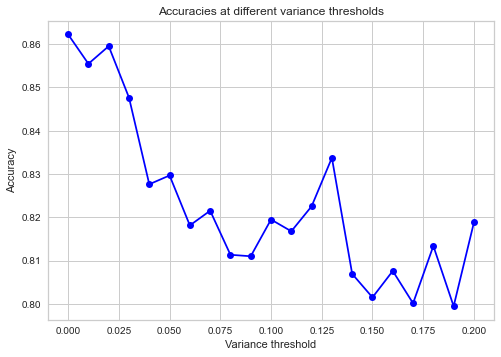

In [16]:
plt.plot(thresholds, Acc_list, marker = "o", color = 'blue')
plt.title("Accuracies at different variance thresholds")
plt.xlabel("Variance threshold") 
plt.ylabel("Accuracy")
plt.show()

#### Best Threshold

In [17]:
sel = VarianceThreshold(threshold=.025) #(.9 * (1 - .9))
X_train_sel = sel.fit_transform(X_train)
X_train_sel.shape 

X_test_sel = sel.transform(X_test)

In [49]:
X_train_sel.shape

(7352, 123)

Fitting 3 folds for each of 126 candidates, totalling 378 fits

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       random_state=42)

Accuracy 0.842551747539871
F1-score 0.8409100772615135
Precision: 0.8432471799236205
Recall: 0.842551747539871
              precision    recall  f1-score   support

           1       0.82      0.91      0.86       496
           2       0.83      0.68      0.75       471
           3       0.80      0.85      0.82       420
           4       0.80      0.76      0.78       491
           5       0.79      0.83      0.81       532
           6       1.00      1.00      1.00       537

    accuracy                           0.84      2947
   macro avg       0.84      0.84      0.84      2947
weighted avg       0.84      0.84      0.84      2947


=== CROSS VALIDATION SCORES ===
Accuracy: 0.8781 (+/- 0.046)
F1-score: 0.

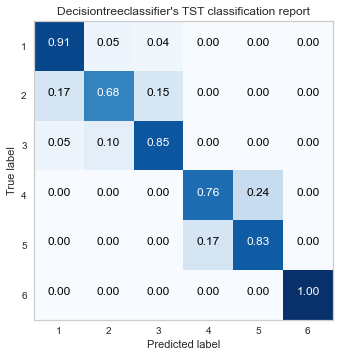

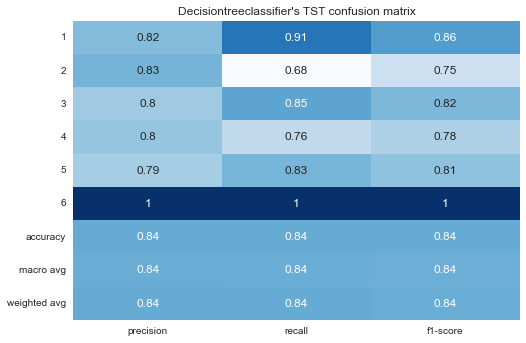

In [18]:
tune_model(DT, DT_params, X_train_sel, y_train, X_test_sel,y_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits

{'n_neighbors': 18, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=18)

Accuracy 0.8927723108245673
F1-score 0.8921038146259174
Precision: 0.9006353037301587
Recall: 0.8927723108245673
              precision    recall  f1-score   support

           1       0.83      0.98      0.90       496
           2       0.88      0.90      0.89       471
           3       0.98      0.75      0.85       420
           4       0.90      0.80      0.85       491
           5       0.82      0.95      0.88       532
           6       1.00      0.94      0.97       537

    accuracy                           0.89      2947
   macro avg       0.90      0.89      0.89      2947
weighted avg       0.90      0.89      0.89      2947


=== CROSS VALIDATION SCORES ===
Accuracy: 0.8987 (+/- 0.030)
F1-score: 0.8959 (+/- 0.033)


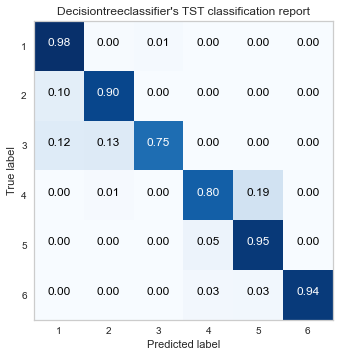

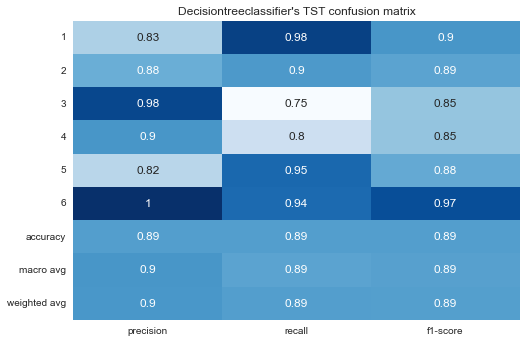

In [20]:
scaler.fit(X_train_sel)
X_train_norm = scaler.transform(X_train_sel)
X_test_norm = scaler.transform(X_test_sel)

tune_model(KNN, KNN_params, X_train_norm, y_train, X_test_norm,y_test)

# Principal Component Analysis

#### Test different # of components

In [23]:
from sklearn.decomposition import PCA

In [24]:
n_components = list(np.linspace(0.6, 0.99, 21))
Acc_list = []


for n in n_components:
    #selector, _ = variance_threshold_selection(X_train, t, True)
    
    
    pca = PCA(n_components=n)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    clf = DecisionTreeClassifier( random_state=42)
    clf.fit(X_train_pca, y_train)

    y_pred = clf.predict(X_test_pca)
    print('numero di componenti: %s' % n)
    print('---Accuracy %s' % accuracy_score(y_test, y_pred))
    Acc_list.append(accuracy_score(y_test, y_pred))
    print('---F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
    print('-------------------------')
    #print(classification_report(y_test, y_pred))

numero di componenti: 0.6
---Accuracy 0.41024770953512046
---F1-score 0.4114718832168383
-------------------------
numero di componenti: 0.6194999999999999
---Accuracy 0.41024770953512046
---F1-score 0.4114718832168383
-------------------------
numero di componenti: 0.639
---Accuracy 0.5110281642348151
---F1-score 0.5095065125123663
-------------------------
numero di componenti: 0.6585
---Accuracy 0.5110281642348151
---F1-score 0.5095065125123663
-------------------------
numero di componenti: 0.6779999999999999
---Accuracy 0.6929080420766881
---F1-score 0.691790818818149
-------------------------
numero di componenti: 0.6975
---Accuracy 0.6929080420766881
---F1-score 0.691790818818149
-------------------------
numero di componenti: 0.717
---Accuracy 0.7159823549372243
---F1-score 0.7155233078761958
-------------------------
numero di componenti: 0.7364999999999999
---Accuracy 0.7519511367492365
---F1-score 0.7519329718089672
-------------------------
numero di componenti: 0.756
---Ac

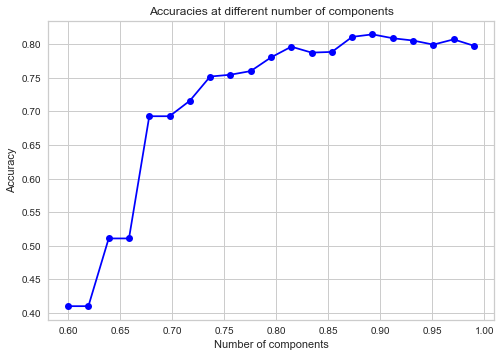

In [25]:
plt.plot(n_components, Acc_list, marker = "o", color = 'blue')
plt.title("Accuracies at different number of components")
plt.xlabel("Number of components") 
plt.ylabel("Accuracy")
plt.show()

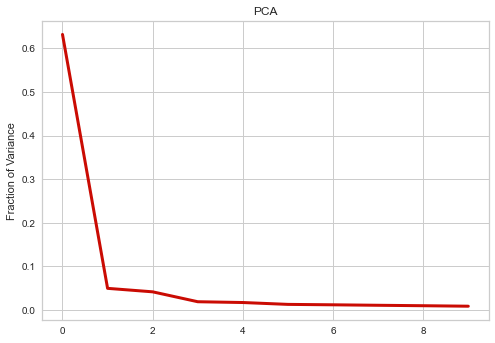

In [26]:
plt.plot(PCA(n_components=10).fit(X_train_pca).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.show()

#### Best  # of components

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=0.90) # precedentemente impostato a 0.95
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print('Training set shape:', X_train_pca.shape)

Training set shape: (7352, 34)


Fitting 3 folds for each of 126 candidates, totalling 378 fits

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10}
DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

Accuracy 0.8150661689854088
F1-score 0.8138369044253626
Precision: 0.8210625850618404
Recall: 0.8150661689854088
              precision    recall  f1-score   support

           1       0.76      0.93      0.84       496
           2       0.85      0.73      0.78       471
           3       0.79      0.71      0.75       420
           4       0.78      0.68      0.73       491
           5       0.74      0.87      0.80       532
           6       0.99      0.94      0.97       537

    accuracy                           0.82      2947
   macro avg       0.82      0.81      0.81      2947
weighted avg       0.82      0.82      0.81      2947


=== CROSS VALIDATION SCORES ===
Accuracy: 0.7949 (+/- 0.056)
F1-score: 0.7

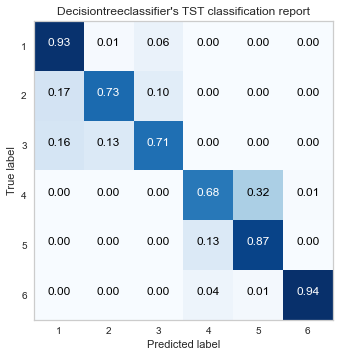

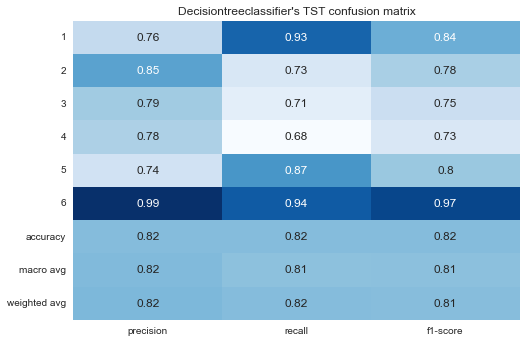

In [29]:
tune_model(DT, DT_params, X_train_pca, y_train, X_test_pca,y_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits

{'n_neighbors': 18, 'weights': 'distance'}
KNeighborsClassifier(n_neighbors=18, weights='distance')

Accuracy 0.8523922633186292
F1-score 0.8522554690262979
Precision: 0.8625673552442047
Recall: 0.8523922633186292
              precision    recall  f1-score   support

           1       0.76      0.96      0.85       496
           2       0.86      0.76      0.81       471
           3       0.96      0.73      0.83       420
           4       0.82      0.79      0.80       491
           5       0.78      0.89      0.83       532
           6       1.00      0.96      0.98       537

    accuracy                           0.85      2947
   macro avg       0.86      0.85      0.85      2947
weighted avg       0.86      0.85      0.85      2947


=== CROSS VALIDATION SCORES ===
Accuracy: 0.8701 (+/- 0.036)
F1-score: 0.8682 (+/- 0.038)


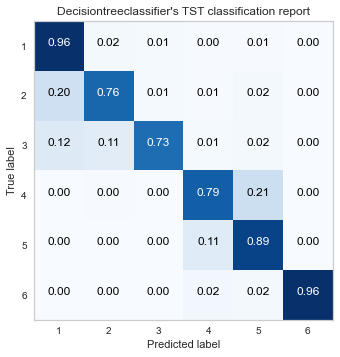

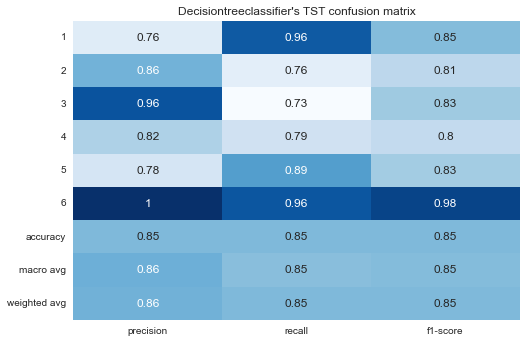

In [30]:
scaler.fit(X_train_pca)
X_train_norm = scaler.transform(X_train_pca)
X_test_norm = scaler.transform(X_test_pca)

tune_model(KNN, KNN_params, X_train_norm, y_train, X_test_norm,y_test)

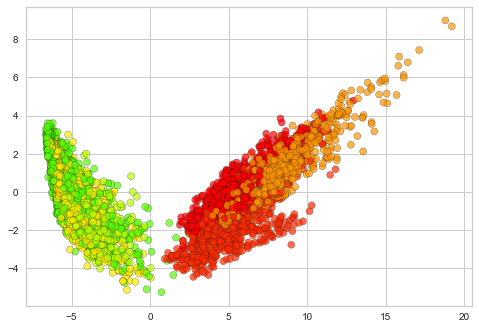

In [31]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7) 
plt.show()

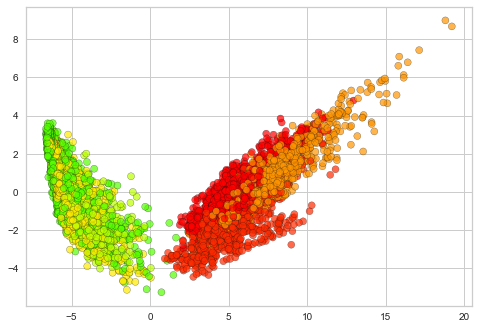

In [32]:
pca = PCA(n_components=2) # precedentemente impostato a 0.95
pca.fit(X_train)
X_train_pca_vis = pca.transform(X_train)
X_test_pca_vis = pca.transform(X_test)

plt.scatter(X_train_pca_vis[:, 0], X_train_pca_vis[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7) 
plt.show()

# Univariate Feature Selection

In [8]:
from sklearn.feature_selection import SelectKBest

#### Test different k

In [34]:
k_columns = list(np.linspace(10, 500, 40))
Acc_list = []


for n_k in k_columns:
    print('numero di colonne k: %s' % int(n_k))
    #selector, _ = variance_threshold_selection(X_train, t, True)
    sel = SelectKBest(k=int(n_k))
    X_train_uni_sel = sel.fit_transform(X_train, y_train)
    X_test_uni_sel = sel.transform(X_test)
    
    clf = DecisionTreeClassifier( random_state=42)
    clf.fit(X_train_uni_sel, y_train)

    y_pred = clf.predict(X_test_uni_sel)
    
    print('---Accuracy %s' % accuracy_score(y_test, y_pred))
    Acc_list.append(accuracy_score(y_test, y_pred))
    print('---F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
    print('-------------------------')
    #print(classification_report(y_test, y_pred))

numero di colonne k: 10
---Accuracy 0.6956226671191041
---F1-score 0.6957144264320049
-------------------------
numero di colonne k: 22
---Accuracy 0.7902952154733628
---F1-score 0.789605912525954
-------------------------
numero di colonne k: 35
---Accuracy 0.7940278249066848
---F1-score 0.7932667584672186
-------------------------
numero di colonne k: 47
---Accuracy 0.7923311842551748
---F1-score 0.7910222904012154
-------------------------
numero di colonne k: 60
---Accuracy 0.8018323719036308
---F1-score 0.8015125562895844
-------------------------
numero di colonne k: 72
---Accuracy 0.825924669155073
---F1-score 0.8256300267433261
-------------------------
numero di colonne k: 85
---Accuracy 0.836104513064133
---F1-score 0.835855205221709
-------------------------
numero di colonne k: 97
---Accuracy 0.8245673566338649
---F1-score 0.8242671713396572
-------------------------
numero di colonne k: 110
---Accuracy 0.835086528673227
---F1-score 0.8350461696057297
----------------------

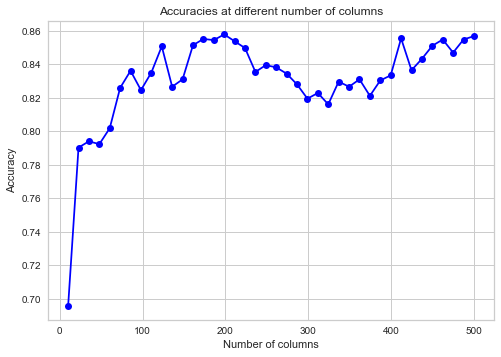

In [35]:
plt.plot(k_columns, Acc_list, marker = "o", color = 'blue')
plt.title("Accuracies at different number of columns")
plt.xlabel("Number of columns") 
plt.ylabel("Accuracy")
plt.show()

#### Best k

In [9]:
sel = SelectKBest(k=200) 
X_train_uni_sel = sel.fit_transform(X_train, y_train)
X_test_uni_sel = sel.transform(X_test)
X_train_uni_sel.shape

(7352, 200)

Fitting 3 folds for each of 126 candidates, totalling 378 fits

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

Accuracy 0.8574821852731591
F1-score 0.8574027827617066
Precision: 0.8585673401392796
Recall: 0.8574821852731591
              precision    recall  f1-score   support

           1       0.81      0.86      0.83       496
           2       0.80      0.80      0.80       471
           3       0.88      0.81      0.84       420
           4       0.84      0.79      0.81       491
           5       0.82      0.86      0.84       532
           6       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.85      0.85      2947
weighted avg       0.86      0.86      0.86      2947


=== CROSS VALIDATION SCORES ===
Accuracy: 0.8615 (+/- 0.048)
F1-score: 0.8508 (+/- 0.052)


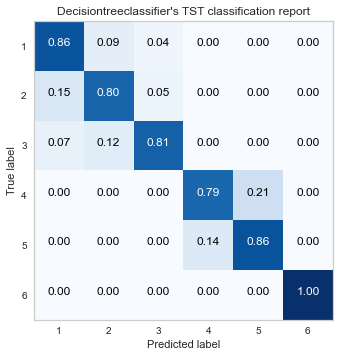

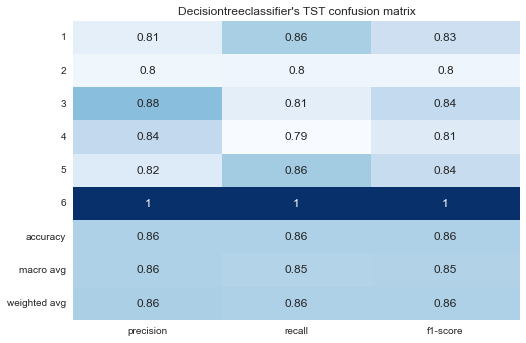

In [10]:
tune_model(DT, DT_params, X_train_uni_sel, y_train, X_test_uni_sel,y_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits

{'n_neighbors': 16, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=16)

Accuracy 0.8985408890397014
F1-score 0.8980056577823597
Precision: 0.9034350451131932
Recall: 0.8985408890397014
              precision    recall  f1-score   support

           1       0.83      0.96      0.89       496
           2       0.84      0.85      0.85       471
           3       0.96      0.78      0.86       420
           4       0.93      0.82      0.88       491
           5       0.86      0.94      0.90       532
           6       1.00      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.90      0.89      0.90      2947
weighted avg       0.90      0.90      0.90      2947


=== CROSS VALIDATION SCORES ===
Accuracy: 0.9078 (+/- 0.032)
F1-score: 0.9030 (+/- 0.035)


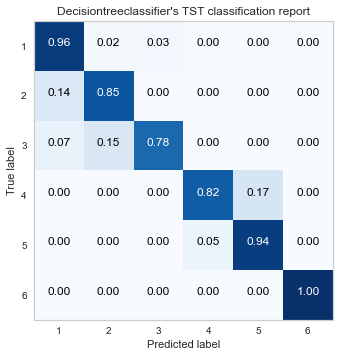

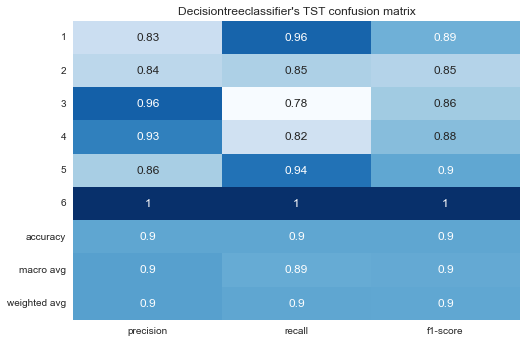

In [39]:
scaler.fit(X_train_uni_sel)
X_train_norm = scaler.transform(X_train_uni_sel)
X_test_norm = scaler.transform(X_test_uni_sel)

tune_model(KNN, KNN_params, X_train_norm, y_train, X_test_norm,y_test)

# Recursive Feature Elimination

In [40]:
from sklearn.feature_selection import SelectFromModel

#### Test different estimators


Decision Tree
Finale Shape:  (7352, 33)
Number of columns:  33
---Accuracy 0.8537495758398371
---F1-score 0.8526426615456237
-------------------------
Fitting 3 folds for each of 126 candidates, totalling 378 fits

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=42)

Accuracy 0.8686800135731252
F1-score 0.8676824014148035
Precision: 0.8703016614173705
Recall: 0.8686800135731252
              precision    recall  f1-score   support

           1       0.83      0.95      0.88       496
           2       0.85      0.76      0.80       471
           3       0.89      0.84      0.87       420
           4       0.85      0.77      0.80       491
           5       0.80      0.87      0.83       532
           6       1.00      1.00      1.00       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0

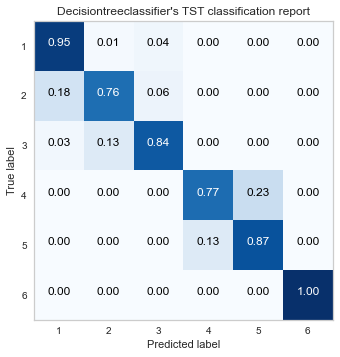

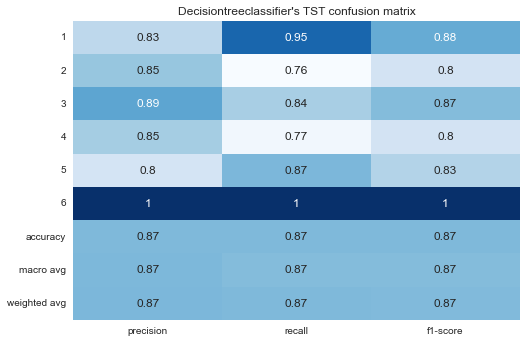


Logistic Regression
Finale Shape:  (7352, 187)
Number of columns:  187
---Accuracy 0.8411944350186631
---F1-score 0.8407512507930568
-------------------------
Fitting 3 folds for each of 126 candidates, totalling 378 fits

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=4, min_samples_leaf=2, random_state=42)

Accuracy 0.831353919239905
F1-score 0.8299470195840709
Precision: 0.8415155699188932
Recall: 0.831353919239905
              precision    recall  f1-score   support

           1       0.73      0.91      0.81       496
           2       0.78      0.80      0.79       471
           3       0.94      0.62      0.75       420
           4       0.79      0.81      0.80       491
           5       0.82      0.80      0.81       532
           6       1.00      1.00      1.00       537

    accuracy                           0.83      2947
   macro avg       0.84      0.82      0.83      2947
weighted avg      

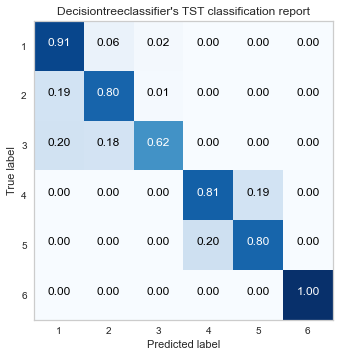

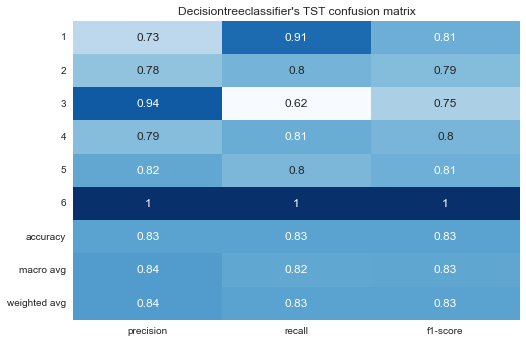


Random Forest
Finale Shape:  (7352, 123)
Number of columns:  123
---Accuracy 0.8744485917882593
---F1-score 0.8736408446943792
-------------------------
Fitting 3 folds for each of 126 candidates, totalling 378 fits

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       random_state=42)

Accuracy 0.8523922633186292
F1-score 0.851476964587854
Precision: 0.8521004813801412
Recall: 0.8523922633186292
              precision    recall  f1-score   support

           1       0.83      0.92      0.87       496
           2       0.80      0.73      0.77       471
           3       0.82      0.79      0.81       420
           4       0.83      0.80      0.81       491
           5       0.82      0.85      0.83       532
           6       1.00      1.00      1.00       537

    accuracy                           0.85      2947
   macro avg       0.85     

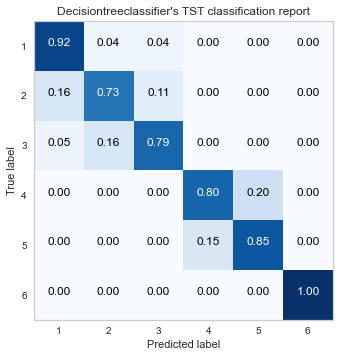

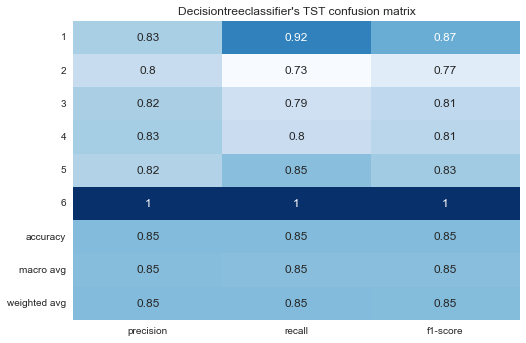

In [41]:
features_rfe_list = []
estimators_list = [DecisionTreeClassifier(random_state=42), LogisticRegression(random_state=42),RandomForestClassifier(random_state=42) ]
estimators_name = ['Decision Tree', 'Logistic Regression', 'Random Forest']
for estimator_name, estimator in zip(estimators_name, estimators_list):
    print()
    print(estimator_name)
    sel = SelectFromModel(estimator) 
    X_train_sel_rfe = sel.fit_transform(X_train, y_train)
    X_test_sel_rfe = sel.transform(X_test)
    features_rfe = X_train.columns[(sel.get_support())]
    
    print('Finale Shape: ', X_train_sel_rfe.shape)
    print('Number of columns: ',len(features_rfe))
    #if estimator_name == 'Decision Tree':
    clf = DecisionTreeClassifier(random_state=42)
    #elif estimator_name == 'Logistic Regression':
        #clf = LogisticRegression(random_state=42)
    #else:
        #clf = RandomForestClassifier(random_state=42)
        
    clf.fit(X_train_sel_rfe, y_train)

    y_pred = clf.predict(X_test_sel_rfe)
    
    print('---Accuracy %s' % accuracy_score(y_test, y_pred))
    Acc_list.append(accuracy_score(y_test, y_pred))
    print('---F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
    print('-------------------------')
    
    tune_model(DT, DT_params, X_train_sel_rfe, y_train, X_test_sel_rfe,y_test)

#### Best  estimator

In [42]:
sel = SelectFromModel(RandomForestClassifier(random_state=42)) 
X_train_sel_rfe = sel.fit_transform(X_train, y_train)
X_test_sel_rfe = sel.transform(X_test)

features_rfe = X_train.columns[(sel.get_support())]

print(len(features_rfe))

123


In [43]:
X_train_rfe = X_train.filter(items=features_rfe)
X_test_rfe = X_test.filter(items=features_rfe)

Fitting 3 folds for each of 126 candidates, totalling 378 fits

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       random_state=42)

Accuracy 0.8523922633186292
F1-score 0.851476964587854
Precision: 0.8521004813801412
Recall: 0.8523922633186292
              precision    recall  f1-score   support

           1       0.83      0.92      0.87       496
           2       0.80      0.73      0.77       471
           3       0.82      0.79      0.81       420
           4       0.83      0.80      0.81       491
           5       0.82      0.85      0.83       532
           6       1.00      1.00      1.00       537

    accuracy                           0.85      2947
   macro avg       0.85      0.85      0.85      2947
weighted avg       0.85      0.85      0.85      2947


=== CROSS VALIDATION SCORES ===
Accuracy: 0.8815 (+/- 0.044)
F1-score: 0

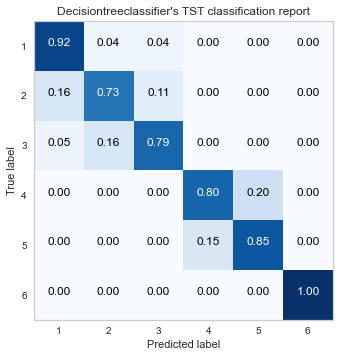

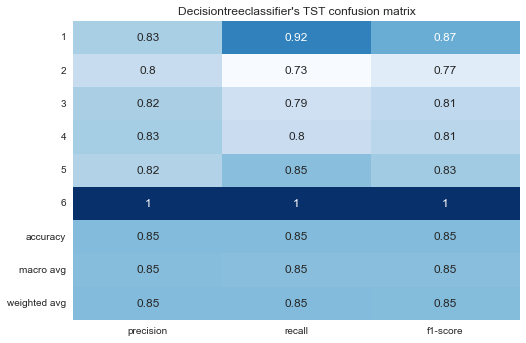

In [44]:
tune_model(DT, DT_params, X_train_rfe, y_train, X_test_rfe,y_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits

{'n_neighbors': 22, 'weights': 'distance'}
KNeighborsClassifier(n_neighbors=22, weights='distance')

Accuracy 0.9009161859518154
F1-score 0.9001930861385662
Precision: 0.9062295610728663
Recall: 0.9009161859518154
              precision    recall  f1-score   support

           1       0.88      0.97      0.92       496
           2       0.89      0.91      0.90       471
           3       0.94      0.81      0.87       420
           4       0.93      0.76      0.84       491
           5       0.80      0.95      0.87       532
           6       1.00      0.98      0.99       537

    accuracy                           0.90      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.91      0.90      0.90      2947


=== CROSS VALIDATION SCORES ===
Accuracy: 0.8954 (+/- 0.043)
F1-score: 0.8935 (+/- 0.045)


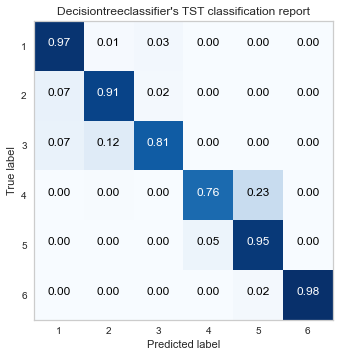

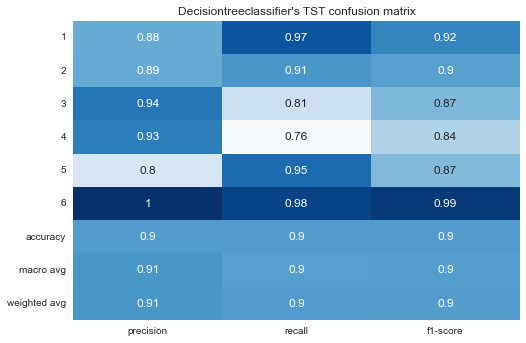

In [45]:
scaler.fit(X_train_rfe)
X_train_norm = scaler.transform(X_train_rfe)
X_test_norm = scaler.transform(X_test_rfe)

tune_model(KNN, KNN_params, X_train_norm, y_train, X_test_norm,y_test)

In [46]:
X_train_sel=pd.DataFrame(X_train_rfe)
X_test_sel=pd.DataFrame(X_test_rfe)
X_train_sel

,tBodyAccstdX,tBodyAccmadX,tBodyAccmaxX,tBodyAccenergyX,tBodyAccentropyX,tBodyAcccorrelationXY,tBodyAcccorrelationYZ,tGravityAccmeanX,tGravityAccmeanY,tGravityAccmeanZ,...,fBodyAccMagstd,fBodyAccMagmad,fBodyAccMagsma,fBodyAccMagenergy,fBodyAccMagentropy,fBodyBodyAccJerkMagmean,fBodyBodyAccJerkMagstd,angleXgravityMean,angleYgravityMean,angleZgravityMean
0,-0.995279,-0.995112,-0.934724,-0.999945,-0.407747,0.376314,0.660790,0.963396,-0.140840,0.115375,...,-0.956134,-0.948870,-0.952155,-0.998285,-0.646376,-0.993726,-0.993755,-0.841247,0.179941,-0.058627
1,-0.998245,-0.998807,-0.943068,-0.999991,-0.714892,-0.013429,0.579382,0.966561,-0.141551,0.109379,...,-0.975866,-0.975777,-0.980857,-0.999472,-0.816674,-0.990335,-0.991960,-0.844788,0.180289,-0.054317
2,-0.995380,-0.996520,-0.938692,-0.999969,-0.592235,-0.124698,0.608900,0.966878,-0.142010,0.101884,...,-0.989015,-0.985594,-0.987795,-0.999807,-0.907014,-0.989280,-0.990867,-0.848933,0.180637,-0.049118
3,-0.996091,-0.997099,-0.938692,-0.999976,-0.627446,-0.305693,0.507459,0.967615,-0.143976,0.099850,...,-0.986742,-0.983524,-0.987519,-0.999770,-0.907014,-0.992769,-0.991700,-0.848649,0.181935,-0.047663
4,-0.998139,-0.998321,-0.942469,-0.999991,-0.786553,-0.155804,0.599213,0.968224,-0.148750,0.094486,...,-0.990063,-0.992324,-0.993591,-0.999873,-0.907014,-0.995523,-0.994389,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,-0.195387,-0.282301,0.210795,-0.674986,0.195643,-0.211822,-0.283335,0.923148,-0.222004,-0.039492,...,-0.232600,-0.007392,-0.097106,-0.584282,0.492474,-0.271514,-0.287553,-0.791883,0.238604,0.049819
7348,-0.235309,-0.322552,0.117440,-0.706359,0.178138,-0.198555,-0.274504,0.918343,-0.242054,-0.039863,...,-0.275373,-0.172448,-0.158161,-0.632536,0.427792,-0.353037,-0.323372,-0.771840,0.252676,0.050053
7349,-0.218218,-0.304515,0.043999,-0.693162,0.173131,-0.226826,-0.198452,0.919810,-0.236950,-0.026805,...,-0.220288,-0.216074,-0.298654,-0.641170,0.466101,-0.424909,-0.326302,-0.779133,0.249145,0.040811
7350,-0.219139,-0.310487,0.101702,-0.693855,0.160333,-0.257775,-0.189915,0.922323,-0.233230,-0.004984,...,-0.234539,-0.220443,-0.346795,-0.663579,0.390648,-0.455183,-0.378077,-0.785181,0.246432,0.025339


### Analisi dataset finale

In [ ]:
sns.heatmap(X_train_sel.corr('pearson'),annot = True, linewidths=.8, cmap= 'coolwarm', vmin=-1, vmax=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Scelta finale

Si è scelta la Univariate Feature selection 

In [57]:
features_DT = X_train.columns[(sel.get_support())]
print(len(features_DT))
features_DT = list(features_DT) + ['Activity']

200


In [58]:
train = pd.read_csv('../data/reduced_cleaned_files/train_reduced_cleaned_4.csv')
train.columns = features_DT
train.to_csv("../data/reduced_cleaned_files/train_reduced_cleaned_withNames.csv",index=False)

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Activity
0,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,...,-0.973653,-0.980135,-0.992656,-0.701291,-0.991990,-0.991990,-0.871306,-0.841247,0.179941,5
1,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,...,-0.982659,-0.988296,-0.993979,-0.720683,-0.995854,-0.995854,-1.000000,-0.844788,0.180289,5
2,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,...,-0.984274,-0.989255,-0.993238,-0.736521,-0.995031,-0.995031,-1.000000,-0.848933,0.180637,5
3,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,-0.576159,-0.829711,0.843609,...,-0.986850,-0.989413,-0.989136,-0.720891,-0.995221,-0.995221,-0.955696,-0.848649,0.181935,5
4,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,-0.569174,-0.824705,0.849095,...,-0.987744,-0.991433,-0.989321,-0.763372,-0.995093,-0.995093,-1.000000,-0.847865,0.185151,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7256,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,0.029369,-0.076700,0.273480,...,-0.128549,-0.332753,-0.292601,0.577573,-0.681097,-0.681097,0.310836,-0.791883,0.238604,2
7257,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,0.029369,-0.031966,0.282174,...,-0.210320,-0.357992,-0.427577,0.620646,-0.682756,-0.682756,0.207930,-0.771840,0.252676,2
7258,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,-0.110405,0.055411,0.263175,...,-0.193130,-0.351948,-0.241789,0.584816,-0.685851,-0.685851,0.158936,-0.779133,0.249145,2
7259,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,-0.149495,0.055411,0.234850,...,-0.171131,-0.415004,-0.513205,0.445207,-0.712131,-0.712131,0.210070,-0.785181,0.246432,2


In [66]:
features_DT = X_train.columns[(sel.get_support())]
print(len(features_DT))
features_DT = list(features_DT) 

X_test = pd.read_csv('../data/reduced_files/X_test_reduced_UFS.csv')
X_test.columns = features_DT

X_test.to_csv("../data/reduced_files/X_test_reduced_UFS_withNames.csv",index=False)


200


In [65]:
X_test

,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,tBodyAccmaxY,tBodyAccmaxZ,tBodyAccminX,...,fBodyBodyGyroMagstd,fBodyBodyGyroMagmad,fBodyBodyGyroMagsma,fBodyBodyGyroMagiqr,fBodyBodyGyroMagentropy,fBodyBodyGyroJerkMagmean,fBodyBodyGyroJerkMagsma,fBodyBodyGyroJerkMagentropy,angleXgravityMean,angleYgravityMean
0,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,-0.554577,-0.466223,0.717208,...,-0.797113,-0.764485,-0.770610,-0.798387,0.179435,-0.890165,-0.890165,-0.234815,-0.720009,0.276801
1,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,-0.554577,-0.806013,0.768031,...,-0.916774,-0.919383,-0.924461,-0.933127,-0.218860,-0.951977,-0.951977,-0.431053,-0.698091,0.281343
2,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,-0.568512,-0.799116,0.848305,...,-0.973998,-0.967097,-0.975209,-0.968260,-0.561266,-0.985689,-0.985689,-0.809976,-0.702771,0.280083
3,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,-0.568512,-0.799116,0.848305,...,-0.971248,-0.966029,-0.976297,-0.975174,-0.566733,-0.985562,-0.985562,-0.849081,-0.698954,0.284114
4,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,-0.560831,-0.825894,0.849179,...,-0.969619,-0.968915,-0.977007,-0.976111,-0.555564,-0.990498,-0.990498,-0.895847,-0.692245,0.290722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,-0.160309,-0.131106,0.354922,...,-0.571234,-0.515544,-0.477844,-0.498796,0.491522,-0.601424,-0.601424,0.365783,-0.651732,0.274627
2943,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,-0.035922,-0.131106,0.414650,...,-0.556577,-0.525429,-0.491855,-0.639320,0.469640,-0.566344,-0.566344,0.402907,-0.655181,0.273578
2944,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,-0.035922,-0.172677,0.402517,...,-0.563327,-0.557262,-0.601283,-0.708982,0.363492,-0.592331,-0.592331,0.364393,-0.655357,0.274479
2945,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,-0.106078,-0.172677,0.357500,...,-0.565917,-0.561972,-0.638555,-0.703218,0.326637,-0.679711,-0.679711,0.238363,-0.659719,0.264782
